# KELOMPOK 6 - DEVISVE CLUSTERING

Notebook ini diperbaiki: preprocessing, agregasi per-produk, scaling, hierarchical clustering (Ward / agglomerative), dendrogram, dan labeling cluster.

Catatan: Ward adalah metode agglomerative (bukan divisive). Di sini kita mengelompokkan *produk* (agregasi per "Jenis Produk").


In [1]:
# Library Import
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline


In [ ]:
# Load data
df = pd.read_csv('data_penjualan.csv', delimiter=';')
df.shape

(1076, 5)

In [3]:
# Tampilkan beberapa baris awal
df.head()

,Tanggal,Jenis Produk,Jumlah Order,Harga,Total
0,05/08/2022,Foodpak260,1000,1800,1800000
1,05/08/2022,FoodpakMatte245,1000,1900,1900000
2,05/08/2022,CraftLaminasi290,5000,750,3750000
3,05/08/2022,CraftLaminasi290,1000,1200,1200000
4,07/08/2022,Dupleks310,1000,1550,1550000


Preprocessing:
- Drop duplikat
- Parse tanggal (opsional)
- Konversi kolom numerik
- Isi nilai Total jika kosong dengan Harga * Jumlah Order


In [4]:
# Drop duplicates
df = df.drop_duplicates().copy()

# Parsing tanggal (jika format dd/mm/YYYY)
if 'Tanggal' in df.columns:
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce')

# Konversi kolom numerik yang penting
num_cols = ['Jumlah Order', 'Harga', 'Total']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Isi NaN numerik dengan 0 (atau bisa diasumsikan lain)
df[num_cols] = df[num_cols].fillna(0)

# Jika Total kosong/0, hitung dari Harga * Jumlah Order
if 'Total' in df.columns and 'Harga' in df.columns and 'Jumlah Order' in df.columns:
    # Jika Total == 0, ganti dengan Harga * Jumlah Order
    mask_zero_total = (df['Total'] == 0)
    df.loc[mask_zero_total, 'Total'] = (df.loc[mask_zero_total, 'Harga'] * df.loc[mask_zero_total, 'Jumlah Order'])

df.head()

,Tanggal,Jenis Produk,Jumlah Order,Harga,Total
0,2022-08-05,Foodpak260,1000,1800,1800000
1,2022-08-05,FoodpakMatte245,1000,1900,1900000
2,2022-08-05,CraftLaminasi290,5000,750,3750000
3,2022-08-05,CraftLaminasi290,1000,1200,1200000
4,2022-08-07,Dupleks310,1000,1550,1550000


Agregasi per produk. Di sini kita kumpulkan metrik yang masuk akal:
- total_order: jumlah order total (sum)
- avg_price: rata-rata harga (mean)
- total_revenue: total revenue (sum dari kolom Total)

Kemudian kita akan menggunakan fitur total_order dan avg_price untuk clustering (menghindari kolinearitas langsung antara fitur jika Total = Harga * Jumlah Order).


In [5]:
# Pastikan kolom 'Jenis Produk' ada
if 'Jenis Produk' not in df.columns:
    raise ValueError("Kolom 'Jenis Produk' tidak ditemukan di data")

data_produk = df.groupby('Jenis Produk').agg(
    total_order=('Jumlah Order', 'sum'),
    avg_price=('Harga', 'mean'),
    total_revenue=('Total', 'sum')
).sort_values('total_revenue', ascending=False)

data_produk.reset_index(inplace=True)
data_produk.head()

,Jenis Produk,total_order,avg_price,total_revenue
0,Dupleks310,215100,1750.400000,369140000
1,CraftLaminasi290,293500,1122.083333,326737500
2,Ivory230,186620,1293.611111,224061000
3,Dupleks350,116000,2120.270270,222125000
4,FoodpakMatte245,116500,1343.396226,152900000


In [6]:
# Ringkasan statistik fitur
data_produk[['total_order','avg_price','total_revenue']].describe().round(2)

,total_order,avg_price,total_revenue
count,94.00,94.00,9.400000e+01
mean,21379.87,2449.09,2.614697e+07
std,52503.49,4173.45,6.334957e+07
min,16.00,250.00,1.500000e+05
25%,1000.00,1177.08,1.406250e+06
50%,2607.50,1600.00,3.662500e+06
75%,6375.00,1900.00,9.800000e+06
max,293500.00,33656.67,3.691400e+08


Pilih fitur untuk clustering. Karena total_revenue berhubungan langsung dengan total_order x avg_price, kita akan memilih dua fitur: total_order dan avg_price. Anda bisa juga menggunakan transformasi log jika distrbusi sangat skewed.


In [7]:
# Pilih fitur untuk clustering
features = ['total_order', 'avg_price']
X = data_produk[features].fillna(0).values

# Opsional: transformasi log untuk mengurangi skew (comment/uncomment sesuai kebutuhan)
use_log = True
if use_log:
    # tambahkan small epsilon agar log(0) tidak error
    X = np.log1p(X)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame(X_scaled, columns=features).describe().round(3)

,total_order,avg_price
count,94.000,94.000
mean,0.000,0.000
std,1.005,1.005
min,-2.795,-2.167
25%,-0.631,-0.319
50%,-0.123,0.047
75%,0.351,0.253
max,2.385,3.687


Hierarchical clustering (Ward linkage). Kita plot dendrogram dengan label nama produk.


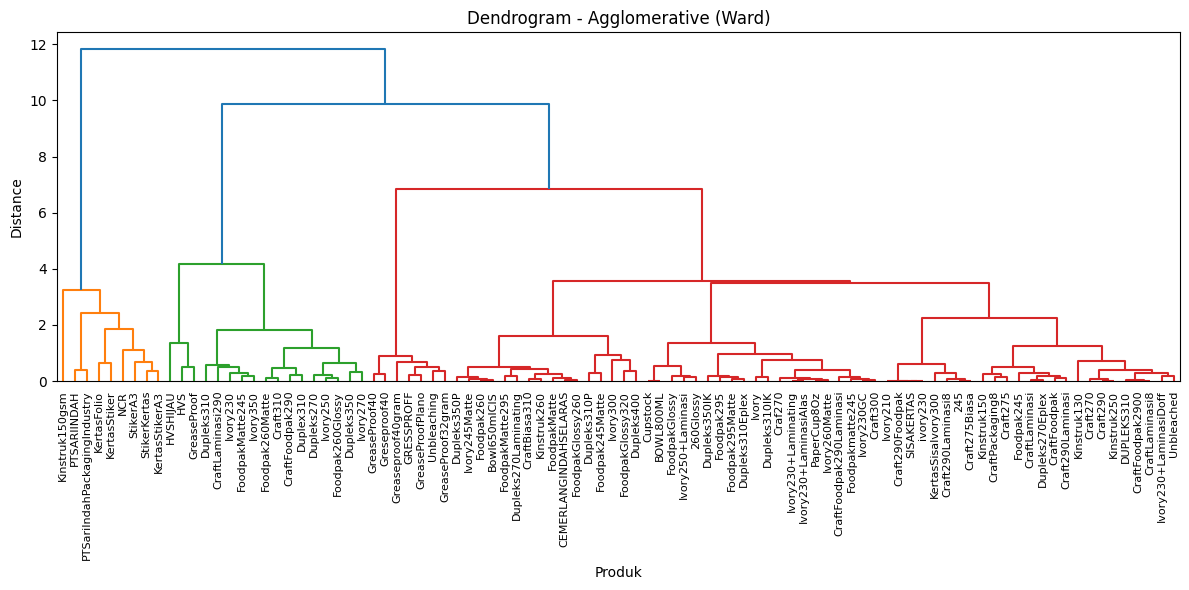

In [ ]:
# Linkage (Ward) dan dendrogram
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 6))
sch.dendrogram(Z, labels=data_produk['Jenis Produk'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram - Agglomerative (Ward)')
plt.xlabel('Produk')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Potong dendrogram untuk memperoleh k cluster. Saya beri contoh k=4 (ubah sesuai kebutuhan).


In [9]:
# Tentukan jumlah cluster dan buat label
k = 4
cluster_labels = fcluster(Z, k, criterion='maxclust')

data_produk['cluster'] = cluster_labels

# Tampilkan ukuran tiap cluster
data_produk['cluster'].value_counts().sort_index()


cluster
1     9
2    17
3     7
4    61
Name: count, dtype: int64

In [10]:
# Tampilkan sampel produk per cluster
for c in sorted(data_produk['cluster'].unique()):
    print(f"\nCluster {c} - n={len(data_produk[data_produk['cluster']==c])}")
    display(data_produk[data_produk['cluster']==c].sort_values('total_revenue', ascending=False).head(10))


Cluster 1 - n=9


,Jenis Produk,total_order,avg_price,total_revenue,cluster
19,Kinstruk150gsm,2715,33656.666667,22743550,1
44,NCR,250,16000.000000,4200000,1
70,StikerA3,250,5500.000000,1375000,1
83,PTSARIINDAH,200,3000.000000,600000,1
84,KertasFolio,50,12000.000000,600000,1
87,StikerKertas,152,10041.333333,435376,1
89,PTSariIndahPackagingIndustry,100,3500.000000,350000,1
91,KertasStiker,16,15000.000000,240000,1
92,KertasStikerA3,205,7750.000000,175000,1



Cluster 2 - n=17


,Jenis Produk,total_order,avg_price,total_revenue,cluster
0,Dupleks310,215100,1750.400000,369140000,2
1,CraftLaminasi290,293500,1122.083333,326737500,2
2,Ivory230,186620,1293.611111,224061000,2
3,Dupleks350,116000,2120.270270,222125000,2
4,FoodpakMatte245,116500,1343.396226,152900000,2
5,Ivory270,65100,2200.000000,131230000,2
6,Ivory350,124000,1168.750000,118600000,2
7,Ivory250,61000,1527.450980,91100000,2
8,Foodpak260Glossy,57500,1650.000000,88900000,2
9,Dupleks270,42500,1725.000000,69150000,2



Cluster 3 - n=7


,Jenis Produk,total_order,avg_price,total_revenue,cluster
79,Unbleaching,2000,400.0,800000,3
80,GreaseProof40,3000,275.0,800000,3
85,Greseproof40,2000,250.0,500000,3
86,GRESSPROFF,1500,300.0,450000,3
88,GreaseProof32gram,1000,400.0,400000,3
90,GreaseProofPlano,1000,300.0,300000,3
93,Greaseproof40gram,500,300.0,150000,3



Cluster 4 - n=61


,Jenis Produk,total_order,avg_price,total_revenue,cluster
10,Ivory300,27000,2585.416667,61875000,4
17,FoodpakGlossy320,9000,3171.428571,29000000,4
18,Dupleks310P,15000,1681.250000,23800000,4
20,Dupleks400,7000,2392.857143,16750000,4
21,Foodpak245Matte,9000,1600.000000,13800000,4
22,Dupleks350P,6000,1875.000000,10500000,4
23,Foodpak245,8000,1214.285714,10000000,4
24,FoodpakMatte295,4000,2300.000000,9200000,4
25,Ivory245Matte,5000,1800.000000,9000000,4
26,Foodpak260,5000,1740.000000,8700000,4


Visualisasi cluster di ruang 2D (fitur yang dipilih). Jika Anda memakai log-transform dan scaling, sumbu di plot adalah fitur tertransformasi.


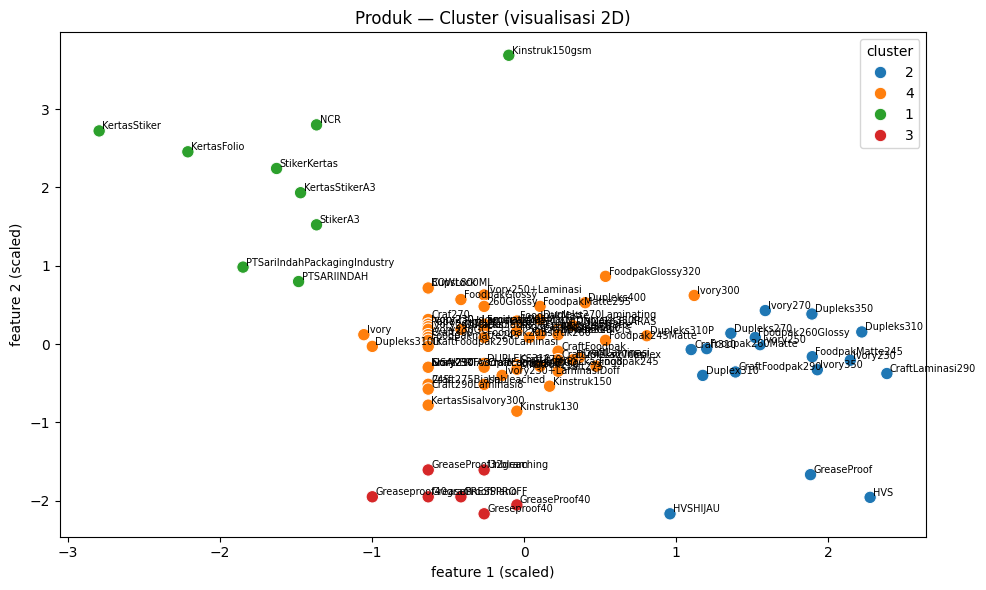

In [11]:
# Scatter plot cluster
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=data_produk['cluster'].astype(str), palette='tab10', s=80)
for i, txt in enumerate(data_produk['Jenis Produk']):
    plt.text(X_scaled[i,0]+0.02, X_scaled[i,1]+0.02, txt, fontsize=7)
plt.xlabel('feature 1 (scaled)')
plt.ylabel('feature 2 (scaled)')
plt.title('Produk — Cluster (visualisasi 2D)')
plt.legend(title='cluster')
plt.tight_layout()
plt.show()

Simpan hasil agregasi + cluster ke CSV untuk penggunaan selanjutnya.


In [ ]:
output_file = 'data_produk_clustered.csv'
data_produk.to_csv(output_file, index=False)
print('Saved:', output_file)

Saved: data_produk_clustered.csv


Kesimpulan singkat:
- Notebook sudah diperbaiki agar clustering dijalankan pada agregat per-produk.
- Variabel yang hilang/keliru (aggr_df_scaled, num_cols, dsb.) sudah diganti dengan pipeline yang konsisten.
- Ward dipakai sebagai metode agglomerative dan dendrogram ditampilkan dengan label produk.

Langkah berikutnya (opsional):
- Ubah jumlah cluster `k` sesuai tujuan analisis dan interpretasi bisnis.
- Gunakan transformasi/feature engineering lain (mis. RFM, frekuensi, recency) jika tujuan pengelompokan berbeda.
- Jika ingin clustering baris transaksi, saya bisa adaptasi notebook sehingga sample = transaksi (dengan one-hot encoding untuk produk).
